In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as XGB
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold, train_test_split
import gc # 对已经销毁的对象,Python不会自动释放其占据的内存空间。为了能够充分地利用分配的内存,避免程序跑到一半停止,要时不时地进行内存回收
import shap


In [3]:
feature_list=['Class','Alcohol','Malic acid','Ash','Alcalinity of ash','Magnesium','Total phenols','Flavanoids','Nonflavanoid phenols','Proanthocyanins','Color intensity','Hue','OD280/OD315 of diluted wines','Proline']

data = pd.read_csv("wine.data",header=None)
data.columns =feature_list
data['Class'].astype(dtype=int)

0      1
1      1
2      1
3      1
4      1
      ..
173    3
174    3
175    3
176    3
177    3
Name: Class, Length: 178, dtype: int32

In [4]:
data.isna().any(axis=0) # 无缺失值

Class                           False
Alcohol                         False
Malic acid                      False
Ash                             False
Alcalinity of ash               False
Magnesium                       False
Total phenols                   False
Flavanoids                      False
Nonflavanoid phenols            False
Proanthocyanins                 False
Color intensity                 False
Hue                             False
OD280/OD315 of diluted wines    False
Proline                         False
dtype: bool

In [5]:
data.duplicated().sum() # 无重复记录

0

In [6]:
data.nunique() # 展示各个特征的取值集合大小



Class                             3
Alcohol                         126
Malic acid                      133
Ash                              79
Alcalinity of ash                63
Magnesium                        53
Total phenols                    97
Flavanoids                      132
Nonflavanoid phenols             39
Proanthocyanins                 101
Color intensity                 132
Hue                              78
OD280/OD315 of diluted wines    122
Proline                         121
dtype: int64

In [17]:
# 训练XGBoost
from sklearn.model_selection import GridSearchCV
params={
    'eta':0.3,
    'gamma':0.1,    # == min_split_loss
    'n_estimators':50,
    'objective':'multi:softprob',
    'max_depth':5,
    'learning_rate':0.1,
    'cv':5,
}
clf=XGB.XGBClassifier(**params)
x_train, x_test, y_train, y_test = train_test_split(data.drop(['Class',],axis=1), data['Class'], random_state=7349,train_size=0.8)
clf.fit(x_train,y_train)

[21:07:44] WARNING: ..\src\learner.cc:541: 
Parameters: { cv } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:07:44] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, cv=5, eta=0.3, gamma=0.1,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [18]:
clf.score(x_test,y_test)

0.9166666666666666

In [20]:
X=data.drop(['Class',],axis=1)
y=data['Class']
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

In [49]:
shap_fea='Flavanoids'
shap_c1=pd.DataFrame(shap_values[0],columns=X.columns,index=X.index)
data.groupby(shap_fea).count()
# shap_fea_id=list(X.columns).index(shap_fea)

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
Flavanoids,,,,,,,,,,,,,
0.34,1,1,1,1,1,1,1,1,1,1,1,1,1
0.47,2,2,2,2,2,2,2,2,2,2,2,2,2
0.48,1,1,1,1,1,1,1,1,1,1,1,1,1
0.49,1,1,1,1,1,1,1,1,1,1,1,1,1
0.50,2,2,2,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3.69,1,1,1,1,1,1,1,1,1,1,1,1,1
3.74,1,1,1,1,1,1,1,1,1,1,1,1,1
3.75,1,1,1,1,1,1,1,1,1,1,1,1,1


In [53]:
# 以 shap_fea 每一定区间聚合在一起做shapley meta分析
step=0.25
f_min=np.floor(data[shap_fea].min()/step)*step
f_max=np.ceil(data[shap_fea].max()/step)*step
out_matrix=[]
for i in range(int(1+(f_max-f_min)/step)):
    low=f_min+i*step
    idx=X[shap_fea].map(lambda x:low<=x<low+step)
    if idx.any():
        out_matrix.append([
            round(low+step/2,2),
            np.average(shap_c1[shap_fea].loc[idx]),
            np.average(np.abs(shap_c1[shap_fea].loc[idx])),
        ])

val_shap=pd.DataFrame(out_matrix,columns=['val','mean','abs_mean'],index=range(len(out_matrix)))

In [56]:
val_shap

,val,mean,abs_mean
0,0.38,-0.765092,0.765092
1,0.62,-1.117275,1.117275
2,0.88,-1.005772,1.005772
3,1.12,-1.007725,1.007725
4,1.38,-0.822034,0.822034
5,1.62,-0.768010,0.768010
6,1.88,-0.842727,0.842727
7,2.12,-0.817839,0.817839
8,2.38,-0.175853,0.430114
9,2.62,0.291674,0.291674


Text(0, 0.5, 'mean_shap')

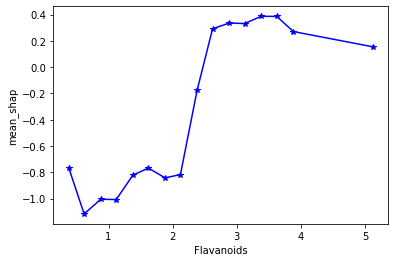

In [61]:
x=list(val_shap['val'])
y_m=list(val_shap['mean'])
y_am=list(val_shap['abs_mean'])
plt.plot(x,y_m,'-*b')
plt.xlabel(shap_fea)
plt.ylabel("mean_shap")